### Output from last week
- Use pipelines
    - This will make your process robust
    - This will prevent data leakage
    - Never fit on a test data set
- Investigate boosting
- Why performs boosting better on this data set than simple logistic regression, what happens under the hood?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

import seaborn as sns
import sys

sys.path.append("/home/luukvanroessel/Documents/ML")

from practice.playground_series.utils import create_model_submission

# Classification with an Academic Success Dataset

## Business Case
- **Goal**: "The goal of this competition is to predict academic risk of students in higher education"
- **Evaluation**: Submissions are evaluated using the accuracy score.
- **Ranking**: The winning solution of this Kaggle competition had an accuracy of 0.8404. My top solution has an accuracy of 0.8346, this would rank me position ~1180/2642

|Iteration | Kaggle result (accuracy)|
|---|---|
|KNN (baseline)| 0.78757|
|Decision tree classifier| 0.73935|
|Decision tree important features| 0.79056|
|Histogram gradient boosting classifier| 0.83415|
|XGBoost classifier | 0.83469|



## Data Analysis

- Outcome: `Target`, one of the following classes for a student: {`Graduate`, `Dropout`, `Enrolled`}
- 36 Different input features: 
    - 7 continuous features with type `float`
    - 29 categorical features with type `int`
- There are no missing values

In [4]:
pd.set_option("display.max_columns", 50)
df = pd.read_csv("train.csv", index_col="id")
df.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.5,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.6,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.0,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout


In [5]:
df.Target.unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

In [6]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,23.425076,8.583196,8.882172,125.363971,0.569265,0.003738,0.071382,0.893646,0.315821,0.247393,22.278653,0.006626,0.188871,5.891516,7.352362,4.178520,9.995862,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,14.921164,17.471591,16.803940,12.562328,0.495182,0.061023,0.257463,0.308292,0.464845,0.431500,6.889241,0.081130,1.175296,1.671776,3.508292,2.687995,5.264224,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,4.000000,4.000000,5.000000,118.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.666667,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,7.000000,7.000000,124.600000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,6.000000,7.000000,5.000000,12.166667,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,132.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,23.000000,0.000000,0.000000,6.000000,9.000000,6.000000,13.314286,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [8]:
df.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

### Split in train and test set

In [9]:
X = df.drop("Target", axis=1)
y = df.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Creating a baseline model

1. One-hot-encoding for categorical features, create infrequent_dummy feature for unknown classes in test dataset
2. Standard scaling for continuous features
3. Use KNN to predict classes; knn automatically accomodates for multiclass problems

In [10]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

In [11]:
categorical_features = df.dtypes[df.dtypes == "int64"].index.tolist()
continuous_features = df.dtypes[df.dtypes == "float64"].index.tolist()
print(f"Overview of number of classes per feature: {df[categorical_features].nunique()}")


Overview of number of classes per feature: Marital status                                     6
Application mode                                  22
Application order                                  8
Course                                            19
Daytime/evening attendance                         2
Previous qualification                            21
Nacionality                                       18
Mother's qualification                            35
Father's qualification                            39
Mother's occupation                               40
Father's occupation                               56
Displaced                                          2
Educational special needs                          2
Debtor                                             2
Tuition fees up to date                            2
Gender                                             2
Scholarship holder                                 2
Age at enrollment                                 46
Int

Let's go for a simple model that already is capable of > 2 classes for the target: KNN

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(handle_unknown="infrequent_if_exist"), categorical_features)
    ])

In [11]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

Baseline model accuracy is 0.788. For this approach, we simply included all raw data in a randomly chosen model.

Let's look at feature importance using decision trees. First, we train a decision tree with default settings

In [13]:
pipeline_tree = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

pipeline_tree.fit(X_train, y_train)
pipeline_tree.score(X_test, y_test)

0.7372582331416623

In [24]:
tree_depth = pipeline_tree.named_steps["classifier"].get_depth()
tree_n_leaves = pipeline_tree.named_steps["classifier"].get_n_leaves()
print(f"Tree depth: {tree_depth}, number of leaves: {tree_n_leaves}")

Tree depth: 38, number of leaves: 9897


<Axes: xlabel='importance'>

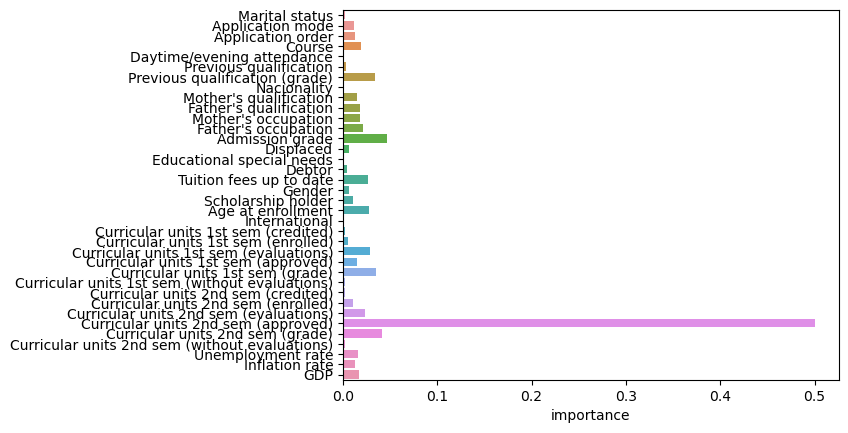

In [25]:
importances = pipeline_tree.named_steps["classifier"].feature_importances_
feature_names = pipeline_tree.named_steps["classifier"].feature_names_in_
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["importance"])
sns.barplot(data=feature_importances, x="importance", y=feature_importances.index)

/tmp/ipykernel_30309/3866973986.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, iteration_df])
/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luukvanroessel/miniconda3/envs/ml-luuk/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Number of features removed')

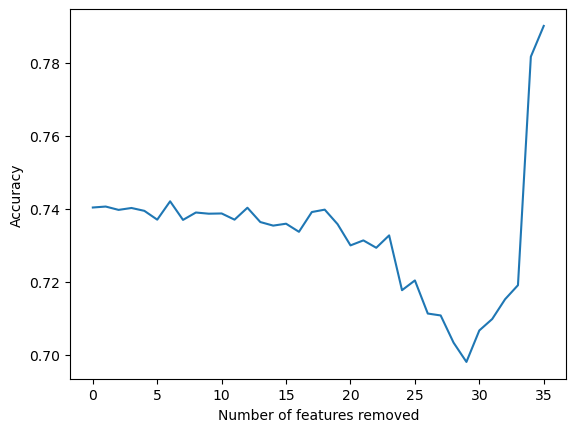

In [28]:
features_left = feature_names.tolist().copy()

df_results = pd.DataFrame(columns=["accuracy", "lowest_importance", "underlying_features"])

for i in range(len(feature_names)):
    
    iteration_dict = {}
    iteration_dict['underlying_features'] = [features_left.copy()]

    pipeline_tree = Pipeline([
        ('classifier', DecisionTreeClassifier())
    ])

    pipeline_tree.fit(X_train[features_left], y_train)

    iteration_dict['accuracy'] = pipeline_tree.score(X_test[features_left], y_test)

    importances = pipeline_tree.named_steps["classifier"].feature_importances_
    feature_importances_names = pipeline_tree.named_steps["classifier"].feature_names_in_
    feature_importances = pd.DataFrame(importances, index=feature_importances_names, columns=["importance"])
    iteration_dict['lowest_importance'] = feature_importances["importance"].idxmin()
    features_left.remove(iteration_dict['lowest_importance'])
    
    iteration_df = pd.DataFrame(iteration_dict, index=[i])

    df_results = pd.concat([df_results, iteration_df])

fig, ax = plt.subplots()
sns.lineplot(data=df_results, x=df_results.index, y="accuracy", ax = ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of features removed")

In [29]:
best_feature = df_results.loc[df_results["accuracy"].idxmax(), 'underlying_features']

pipeline_tree = Pipeline([
    ('classifier', DecisionTreeClassifier())
])
pipeline_tree.fit(X_train[best_feature], y_train)
best_feature_decision_tree_score = pipeline_tree.score(X_test[best_feature], y_test)

print(f"Best feature set: {best_feature}, score: {best_feature_decision_tree_score}")

Best feature set: ['Curricular units 2nd sem (approved)'], score: 0.7901855723993727


### Hist gradient boosting classifier

Why are is sklearn's `HistGradientBoostingClassifier` faster than `GradientBoostingClassifier`?
- Instead of using the exact values of the continuous features, HistGradientBoostingClassifier discretizes these features into bins (histograms). This reduces the number of unique values that need to be considered when finding the best splits for each tree [[Jason Brownlee](https://machinelearningmastery.com/histogram-based-gradient-boosting-ensembles/)]

Why is the gradient boosting classifier more accurate than a decision tree classifier?
1. Ensemble learning: gradient boosting is an ensemble method, meaning it combines the predictions of multiple decision trees to form a more robust model. This approach helps to reduce variance & improve generalization.
2. Gradient boosting builds trees sequentialy, each tree is trained to correct the error of the preivous tree. This iterative approach allows the model to focus on the most difficult-to-predict samples. Leading to better performance
3. Learning rate: also prevents overfitting
4. Handling of Feature Interactions: Gradient boosting methods is better at capturing complex interactions between features due to the sequential addition of trees. Each tree can model interactions that were not captured by previous trees.



In [42]:
pipeline_hgbc = Pipeline([
    ('classifier', HistGradientBoostingClassifier())
])

pipeline_hgbc.fit(X_train, y_train)
pipeline_hgbc.score(X_test, y_test)

0.8357945635128071

In [39]:
pipeline_forest = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipeline_forest.fit(X_train, y_train)
pipeline_forest.score(X_test, y_test)

0.8289336121275483

### Draft

In [33]:
xg_y_train = y_train.astype("category").cat.codes
xg_y_test = y_test.astype("category").cat.codes

xg_clf = XGBClassifier().fit(X_train, xg_y_train)
xg_clf.score(X_test, xg_y_test)

test_df = pd.read_csv("test.csv", index_col="id")
create_model_submission(test_df, xg_clf, "xgboost")

Ideas:
- Mutual information
    - StatQuest: https://www.youtube.com/watch?v=eJIp_mgVLwE&t=379s
    - Kaggle: https://www.kaggle.com/code/ryanholbrook/mutual-information
- PCA
    - Besides dimension reduction, also feature importance
